In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.set_figure_params(dpi_save=600)
adata=sc.read("_Output/adata_SGN.h5ad")

In [2]:
DVD=pd.read_table("_prior/DVD.r8.2.1.2019-12-05.download.tsv.tar.gz")
df_genes=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),"GENE"].unique()
DVD_sub=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),:]
df_genes=np.char.capitalize(np.array(list(map(lambda x: x.split("%20")[0],df_genes))))

/home/lfaure/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


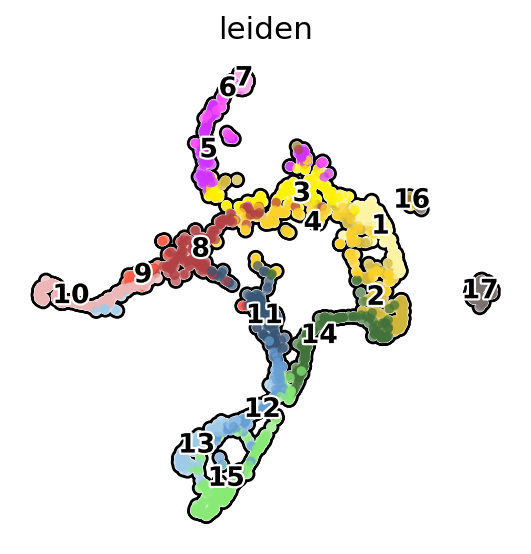

In [3]:
sc.pl.tsne(adata,color="leiden",legend_loc="on data",add_outline=True,legend_fontsize=12, legend_fontoutline=2,frameon=False)
emb_back=adata.obsm["X_tsne"].copy()

In [4]:
df_genes=adata.var_names[adata.var_names.isin(df_genes)]
df=pd.DataFrame(np.vstack(list(map(lambda c: adata[adata.obs.leiden==c,df_genes].layers["fpm"].mean(axis=0),adata.obs.leiden.cat.categories))),
             index=adata.obs.leiden.cat.categories,columns=df_genes)

In [5]:
df_genes=df.columns[df.apply(lambda x: any(x>1))]

In [6]:
non_HC=df_genes[adata[adata.obs.leiden==17,df_genes].layers["scaled"].mean(axis=0)<1.5]
HC=df_genes[adata[adata.obs.leiden==17,df_genes].layers["scaled"].mean(axis=0)>1.5]
non_Otic=df_genes[adata[adata.obs.leiden==16,df_genes].layers["scaled"].mean(axis=0)<1.5]
Otic=df_genes[adata[adata.obs.leiden==16,df_genes].layers["scaled"].mean(axis=0)>1.5]

In [7]:
Others=np.array(list(set(non_HC).intersection(set(non_Otic))))

In [8]:
Others.sort()

In [9]:
HC=np.array(HC)

In [10]:
Otic=np.array(Otic)

In [11]:
HC.sort()
Otic.sort()

In [12]:
dct={"Otic":Otic.tolist(),"HC":HC.tolist(),"Others":Others.tolist()}

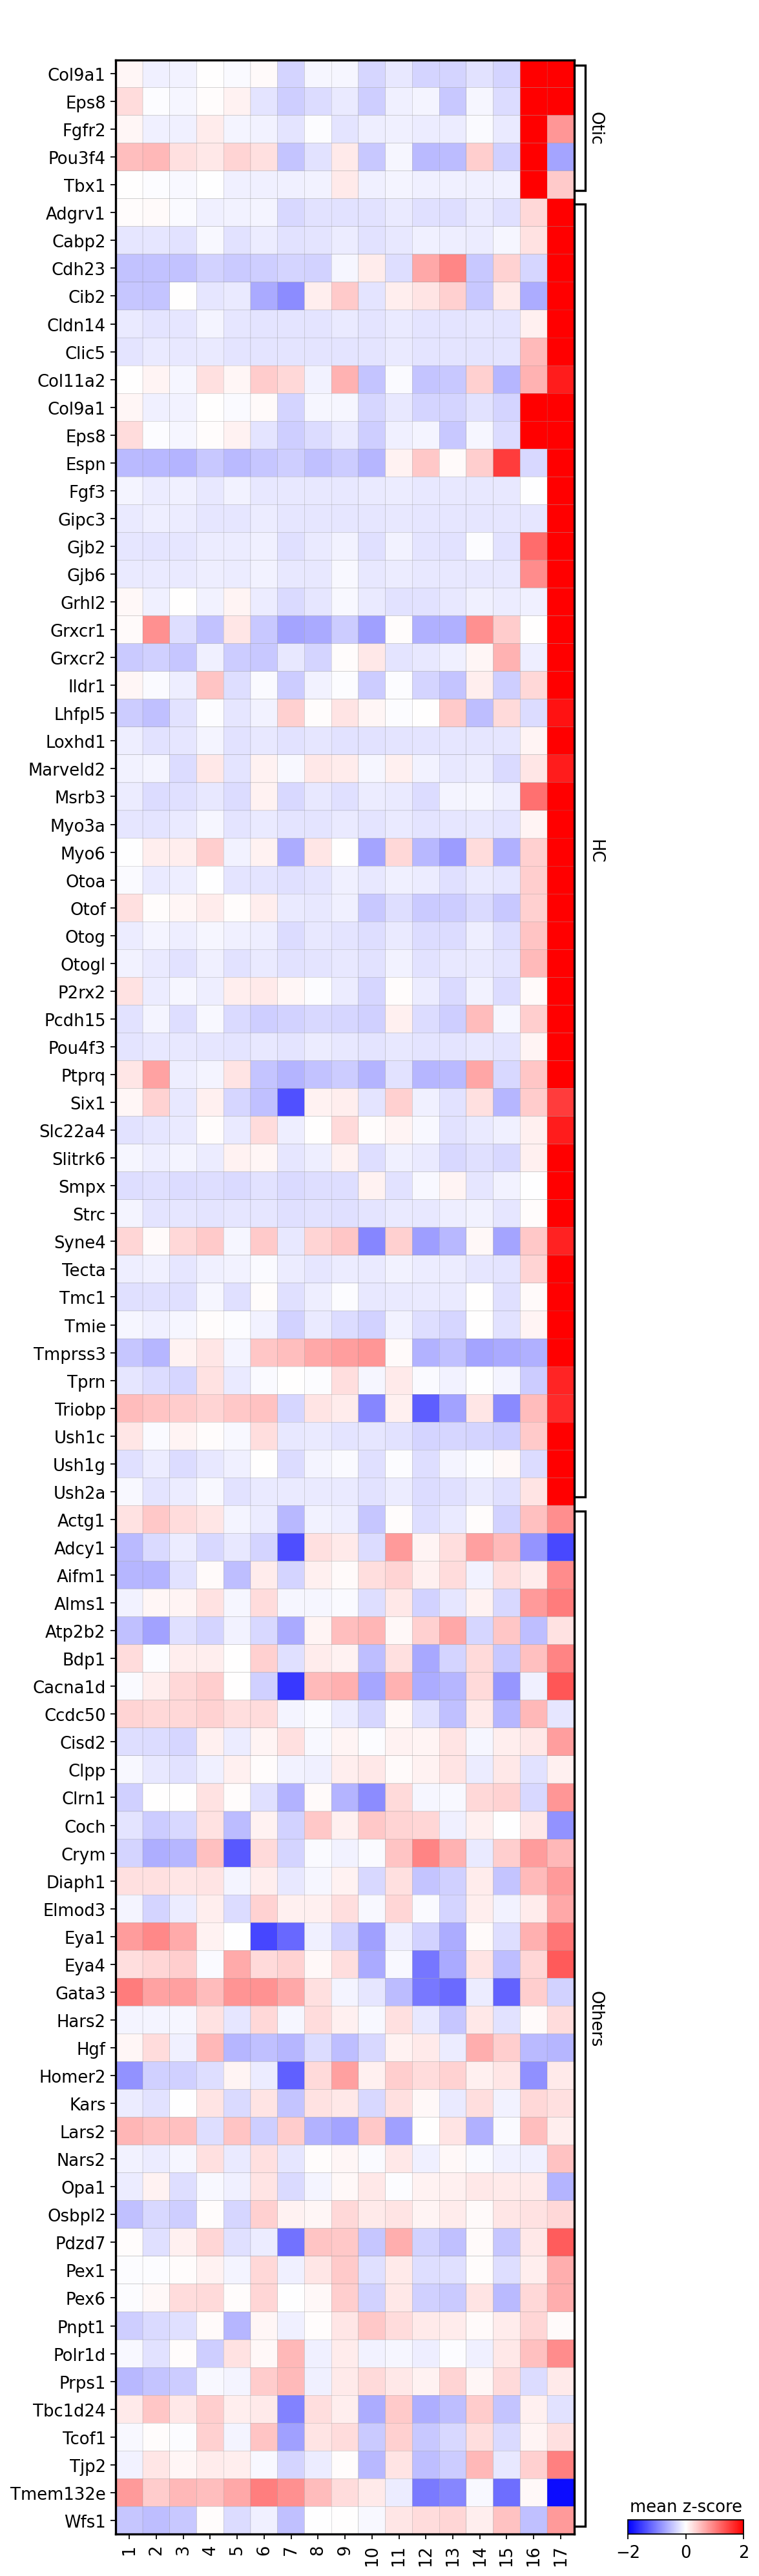

In [13]:
adata.obs.leiden=adata.obs.leiden.cat.reorder_categories(adata.obs.leiden.cat.categories.sort_values())
sc.pl.matrixplot(adata,dct, 'leiden', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-2, vmax=2,swap_axes=True,
                save="DVD_leiden_ordered.png")

In [14]:
df_genes_SGN=np.array(df.loc[~df.index.isin([16,17]),:].columns[df.apply(lambda x: any(x>1))])

In [15]:
df_genes_SGN.sort()

In [16]:
adata_SGN=adata[~adata.obs.leiden.isin([16,17])]

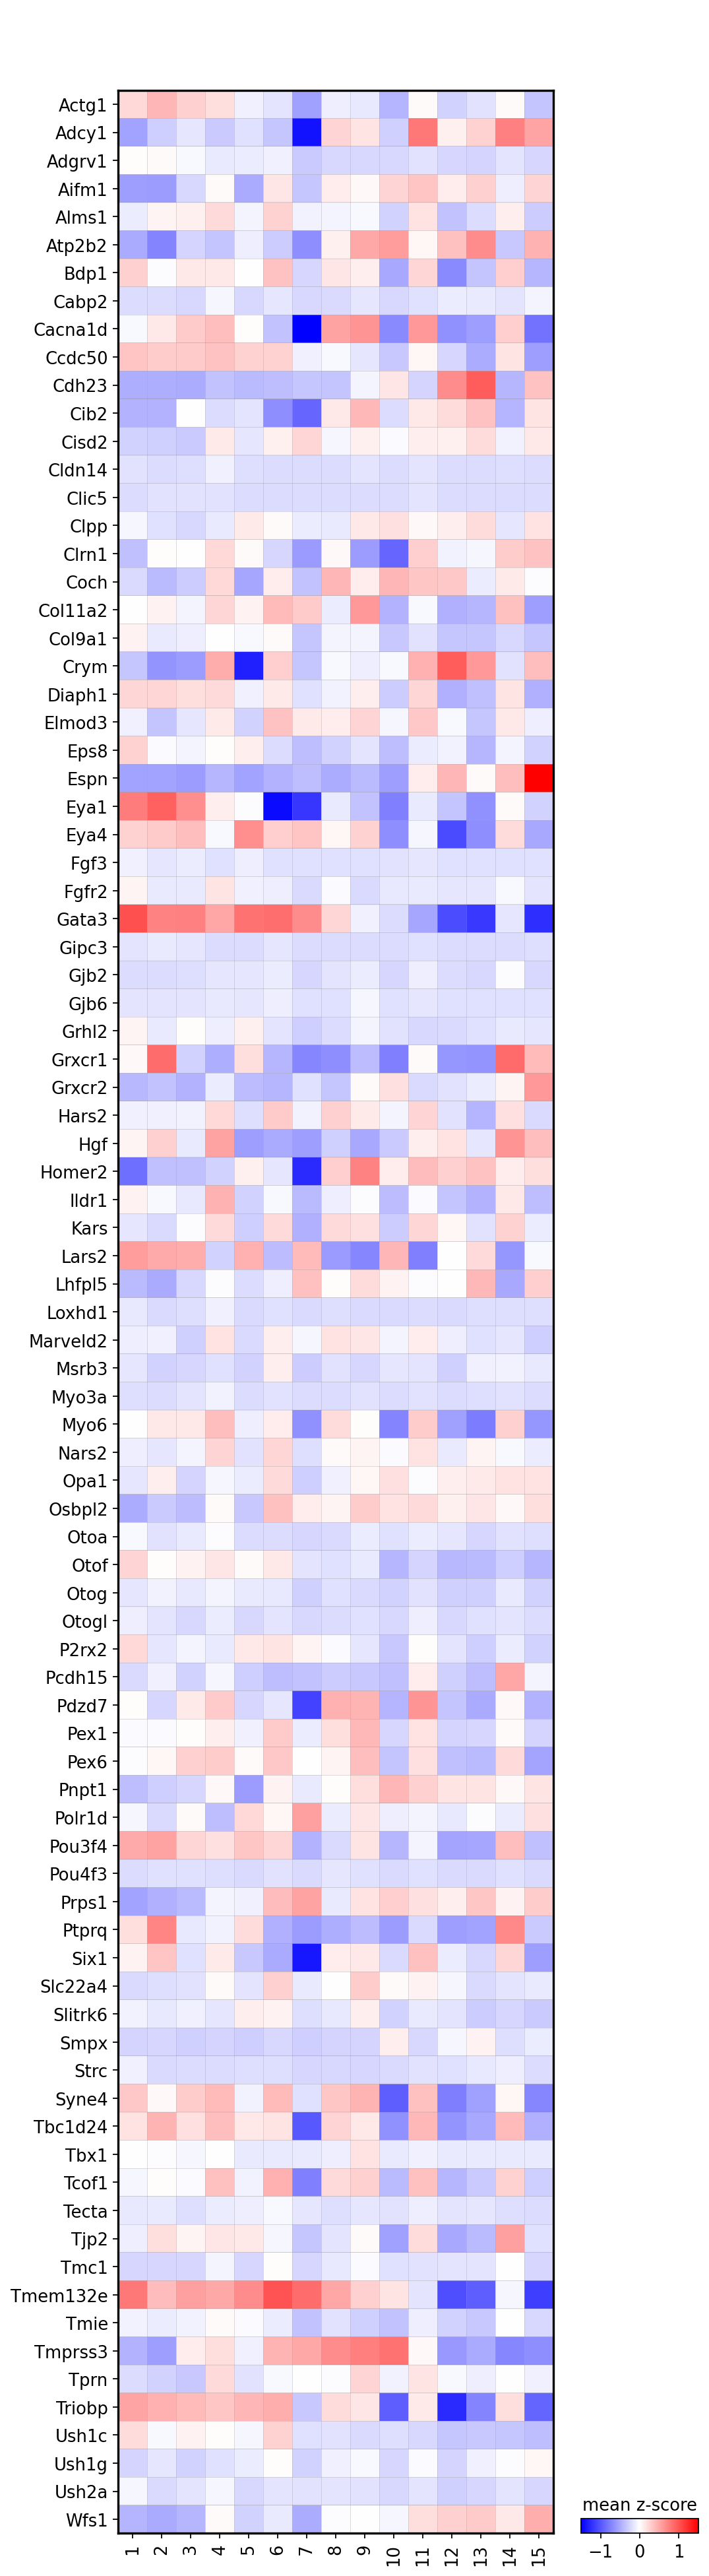

In [17]:
sc.pl.matrixplot(adata_SGN,df_genes_SGN, 'leiden', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-1.5, vmax=1.5,swap_axes=True,
                save="DVD_leiden_ordered_SGN.png")

In [18]:
df_genes_SGN

array(['Actg1', 'Adcy1', 'Adgrv1', 'Aifm1', 'Alms1', 'Atp2b2', 'Bdp1',
       'Cabp2', 'Cacna1d', 'Ccdc50', 'Cdh23', 'Cib2', 'Cisd2', 'Cldn14',
       'Clic5', 'Clpp', 'Clrn1', 'Coch', 'Col11a2', 'Col9a1', 'Crym',
       'Diaph1', 'Elmod3', 'Eps8', 'Espn', 'Eya1', 'Eya4', 'Fgf3',
       'Fgfr2', 'Gata3', 'Gipc3', 'Gjb2', 'Gjb6', 'Grhl2', 'Grxcr1',
       'Grxcr2', 'Hars2', 'Hgf', 'Homer2', 'Ildr1', 'Kars', 'Lars2',
       'Lhfpl5', 'Loxhd1', 'Marveld2', 'Msrb3', 'Myo3a', 'Myo6', 'Nars2',
       'Opa1', 'Osbpl2', 'Otoa', 'Otof', 'Otog', 'Otogl', 'P2rx2',
       'Pcdh15', 'Pdzd7', 'Pex1', 'Pex6', 'Pnpt1', 'Polr1d', 'Pou3f4',
       'Pou4f3', 'Prps1', 'Ptprq', 'Six1', 'Slc22a4', 'Slitrk6', 'Smpx',
       'Strc', 'Syne4', 'Tbc1d24', 'Tbx1', 'Tcof1', 'Tecta', 'Tjp2',
       'Tmc1', 'Tmem132e', 'Tmie', 'Tmprss3', 'Tprn', 'Triobp', 'Ush1c',
       'Ush1g', 'Ush2a', 'Wfs1'], dtype=object)

In [29]:
df=pd.DataFrame(0,index=adata_SGN.obs.leiden.cat.categories,
            columns=df_genes_SGN)

In [30]:
for c in adata_SGN.obs.leiden.cat.categories:
    for g in df_genes_SGN:
        df.loc[c,g]=np.array(adata_SGN[adata_SGN.obs.leiden==c,g].layers["scaled"]).mean()

In [32]:
df.to_csv("supp_Fig5b.csv")

In [33]:
adata=sc.read("_Output/adata_HC.h5ad")

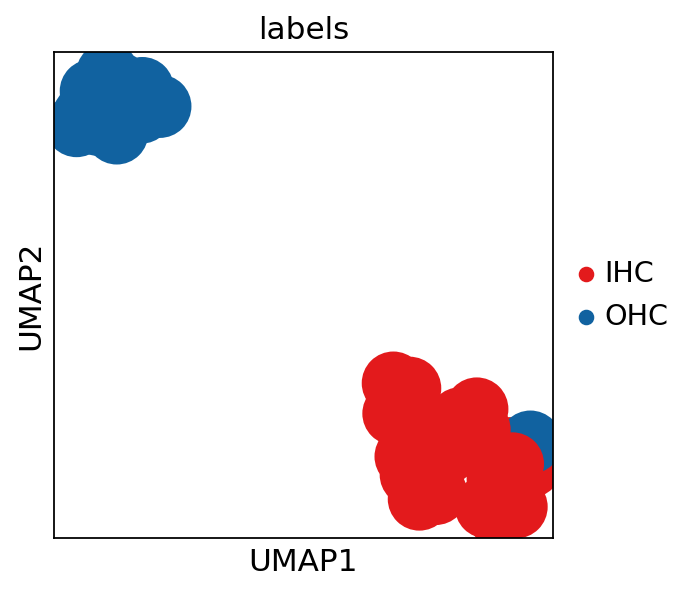

In [34]:
sc.pl.umap(adata, color='labels')

In [35]:
DVD=pd.read_table("_prior/DVD.r8.2.1.2019-12-05.download.tsv.tar.gz")
df_genes=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),"GENE"].unique()
DVD_sub=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),:]
df_genes=np.char.capitalize(np.array(list(map(lambda x: x.split("%20")[0],df_genes))))

/home/lfaure/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [36]:
df_genes=adata.var_names[adata.var_names.isin(df_genes)]
df=pd.DataFrame(np.vstack(list(map(lambda c: adata[adata.obs.leiden==c,df_genes].layers["fpm"].mean(axis=0),adata.obs.leiden.cat.categories))),
             index=adata.obs.labels.cat.categories,columns=df_genes)

In [37]:
df_genes_HC=np.array(df.columns[df.apply(lambda x: any(x>1))])

In [38]:
df_genes_HC.sort()

In [39]:
adata.layers["scaled"]=sc.pp.scale(adata.layers["fpm"],copy=True)

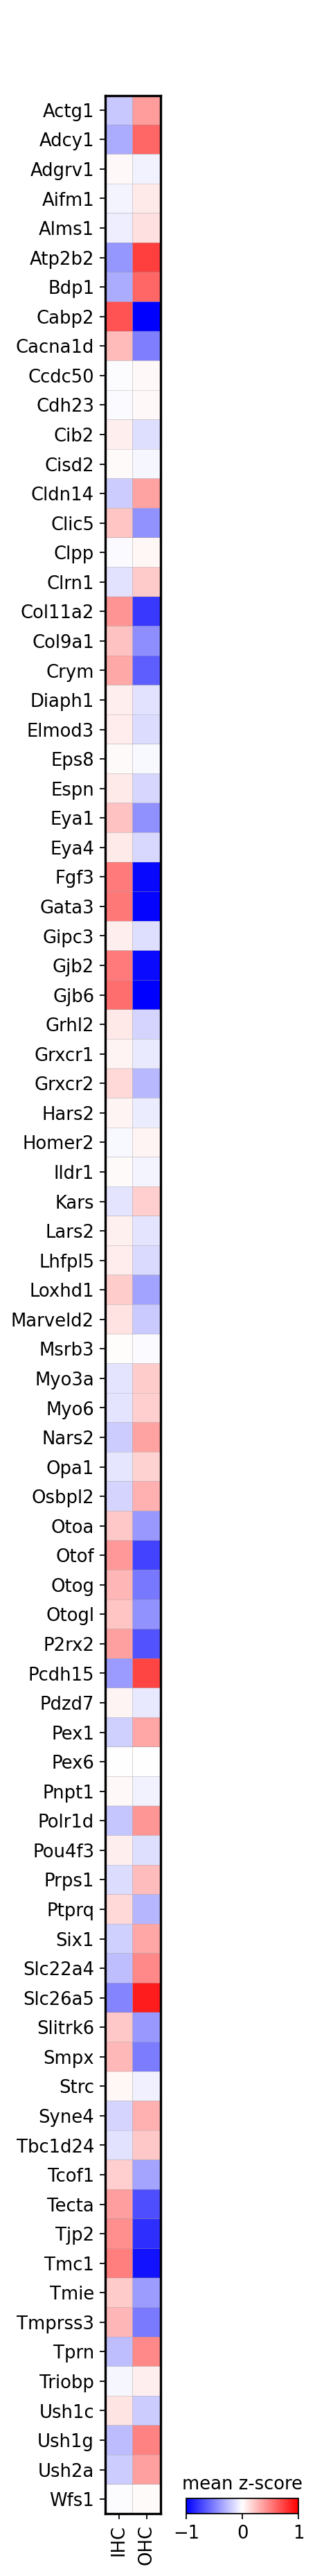

In [40]:
sc.pl.matrixplot(adata,df_genes_HC, 'labels', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-1, vmax=1,swap_axes=True,
                save="DVD_leiden_ordered_HC.png")

In [42]:
df=pd.DataFrame(0,index=adata.obs.labels.cat.categories,
            columns=df_genes_HC)

In [46]:
for c in adata.obs.labels.cat.categories:
    for g in df_genes_HC:
        df.loc[c,g]=np.array(adata[adata.obs.labels==c,g].layers["scaled"]).mean()

In [47]:
df

,Actg1,Adcy1,Adgrv1,Aifm1,Alms1,Atp2b2,Bdp1,Cabp2,Cacna1d,Ccdc50,...,Tjp2,Tmc1,Tmie,Tmprss3,Tprn,Triobp,Ush1c,Ush1g,Ush2a,Wfs1
IHC,-0.211011,-0.321628,0.027839,-0.043591,-0.066444,-0.406388,-0.321859,0.679339,0.271213,-0.014514,...,0.442198,0.501049,0.208351,0.281318,-0.253434,-0.036883,0.107874,-0.264490,-0.199482,-0.009988
OHC,0.389559,0.593775,-0.051396,0.080477,0.122666,0.750255,0.594202,-1.254165,-0.500700,0.026795,...,-0.816366,-0.925013,-0.384647,-0.519357,0.467879,0.068092,-0.199152,0.488289,0.368274,0.018439


In [48]:
df.to_csv("supp_Fig5c.csv")